In [1]:
from aeon.classification.convolution_based import HydraClassifier
from aeon.classification.convolution_based import Arsenal
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.convolution_based import MultiRocketHydraClassifier
import numpy as np
import pandas as pd
import glob
import json
from scipy.signal import resample
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

c:\anaconda3\envs\timeseries\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


S dataset - Left Right - Age Prediction

Hydra Classifier

Accuracy: 0.6


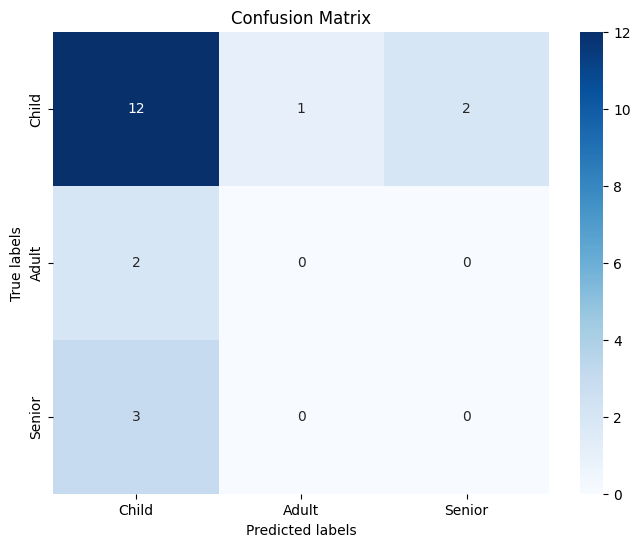

Classification Report:
               precision    recall  f1-score   support

       Child       0.71      0.80      0.75        15
       Adult       0.00      0.00      0.00         2
      Senior       0.00      0.00      0.00         3

    accuracy                           0.60        20
   macro avg       0.24      0.27      0.25        20
weighted avg       0.53      0.60      0.56        20



In [2]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

def resample_signal(x):
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return resample(x, 50, window='hamming', axis=0).flatten().tolist()

def to_nested(df):
    nested_df = pd.DataFrame({
        'keypoints': df['keypoints'],  
        'label': df['label']  
    })
    return nested_df

# Load data for different categories
child_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Children_left_right'   
adult_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Adult_left_right'
senior_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Senior_left_right'

child_data = load_data(child_directory, start_video_id=1)
adult_data = load_data(adult_directory, start_video_id=21)  # Start from 21
senior_data = load_data(senior_directory, start_video_id=41)  # Start from 41

# Assign labels
child_data['label'] = 1
adult_data['label'] = 2
senior_data['label'] = 3

# Combine data
data = pd.concat([child_data, adult_data, senior_data])

grouped_data = data.groupby('video_id').agg({
    'keypoints': lambda x: np.sum(x.tolist(), axis=0),  # Sum keypoints lists
    'label': 'first'
}).reset_index()

# Resample keypoints
grouped_data['keypoints'] = grouped_data['keypoints'].apply(resample_signal)

nested_grouped_data = to_nested(grouped_data)

# Exchange data format
X = np.array(nested_grouped_data['keypoints'].tolist())
y = np.array(nested_grouped_data['label'])

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Reshape data 
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Training on Hydra Classifier
classifier =  HydraClassifier(n_kernels=8, n_groups=64, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train)


# Predicition
y_pred = classifier.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)


Arsenal Classifier

Accuracy: 0.7


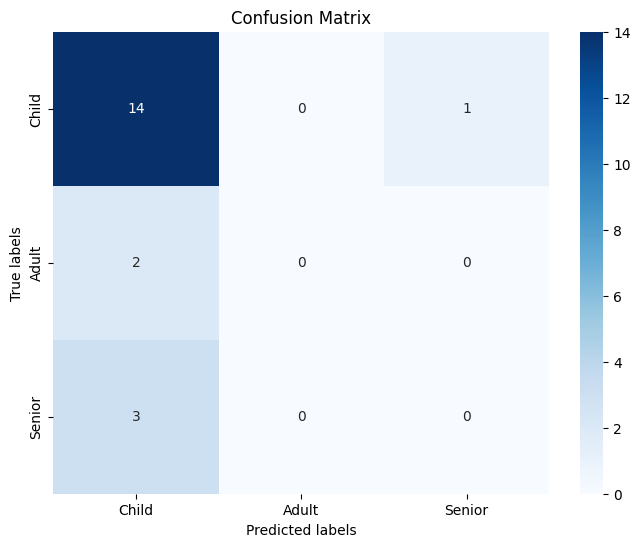

Classification Report:
               precision    recall  f1-score   support

       Child       0.74      0.93      0.82        15
       Adult       0.00      0.00      0.00         2
      Senior       0.00      0.00      0.00         3

    accuracy                           0.70        20
   macro avg       0.25      0.31      0.27        20
weighted avg       0.55      0.70      0.62        20



c:\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda3\envs\timeseries\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

def resample_signal(x):
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return resample(x, 50, window='hamming', axis=0).flatten().tolist()

def to_nested(df):
    nested_df = pd.DataFrame({
        'keypoints': df['keypoints'],  
        'label': df['label']  
    })
    return nested_df

# Load data for different categories
child_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Children_left_right'
adult_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Adult_left_right'
senior_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Senior_left_right'

child_data = load_data(child_directory, start_video_id=1)
adult_data = load_data(adult_directory, start_video_id=21)  # Start from 21
senior_data = load_data(senior_directory, start_video_id=41)  # Start from 41

# Assign labels
child_data['label'] = 1
adult_data['label'] = 2
senior_data['label'] = 3

# Combine data
data = pd.concat([child_data, adult_data, senior_data])

grouped_data = data.groupby('video_id').agg({
    'keypoints': lambda x: np.sum(x.tolist(), axis=0),  # Sum keypoints lists
    'label': 'first'
}).reset_index()

# Resample keypoints
grouped_data['keypoints'] = grouped_data['keypoints'].apply(resample_signal)

nested_grouped_data = to_nested(grouped_data)

# Exchange data format
X = np.array(nested_grouped_data['keypoints'].tolist())
y = np.array(nested_grouped_data['label'])


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# Training on Arsenal Classifier
classifier =  Arsenal(num_kernels=2000, n_estimators=25, rocket_transform='rocket', 
                      max_dilations_per_kernel=32, n_features_per_kernel=4, time_limit_in_minutes=0.0, 
                      contract_max_n_estimators=100, n_jobs=1, random_state=101)
classifier.fit(X_train, y_train)


# Prediction
y_pred = classifier.predict(X_test)

# Accuracu Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)


Rocket Classifier

Accuracy: 0.6


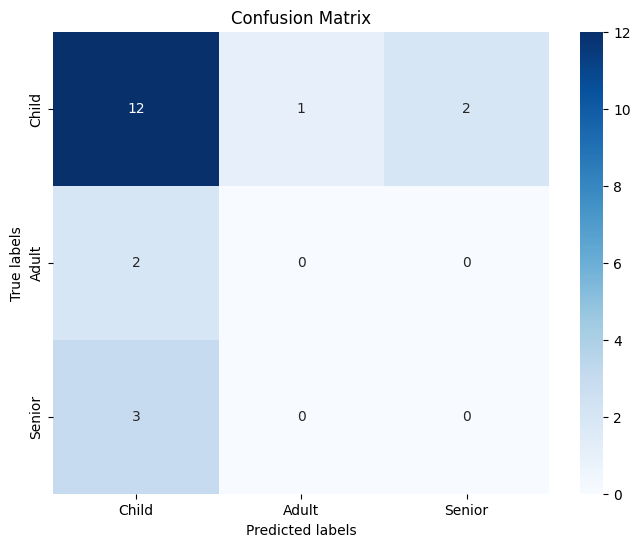

Classification Report:
               precision    recall  f1-score   support

       Child       0.71      0.80      0.75        15
       Adult       0.00      0.00      0.00         2
      Senior       0.00      0.00      0.00         3

    accuracy                           0.60        20
   macro avg       0.24      0.27      0.25        20
weighted avg       0.53      0.60      0.56        20



In [4]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

def resample_signal(x):
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return resample(x, 50, window='hamming', axis=0).flatten().tolist()

def to_nested(df):
    nested_df = pd.DataFrame({
        'keypoints': df['keypoints'],  
        'label': df['label']  
    })
    return nested_df

# Load data for different categories
child_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Children_left_right'
adult_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Adult_left_right'
senior_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Senior_left_right'

child_data = load_data(child_directory, start_video_id=1)
adult_data = load_data(adult_directory, start_video_id=21)  # Start from 21
senior_data = load_data(senior_directory, start_video_id=41)  # Start from 41

# Assign labels
child_data['label'] = 1
adult_data['label'] = 2
senior_data['label'] = 3

# Combine data
data = pd.concat([child_data, adult_data, senior_data])

grouped_data = data.groupby('video_id').agg({
    'keypoints': lambda x: np.sum(x.tolist(), axis=0),  # Sum keypoints lists
    'label': 'first'
}).reset_index()

# Resample keypoints
grouped_data['keypoints'] = grouped_data['keypoints'].apply(resample_signal)

nested_grouped_data = to_nested(grouped_data)

# Exchange data format
X = np.array(nested_grouped_data['keypoints'].tolist())
y = np.array(nested_grouped_data['label'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# Training on Rocket Classifier
classifier =  RocketClassifier(num_kernels=10000, rocket_transform='rocket', max_dilations_per_kernel=32, 
                               n_features_per_kernel=4, estimator=None, random_state=42, n_jobs=1)
classifier.fit(X_train, y_train)


# Prediction
y_pred = classifier.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)


MultiRocketHydraClassifier

Accuracy: 0.5


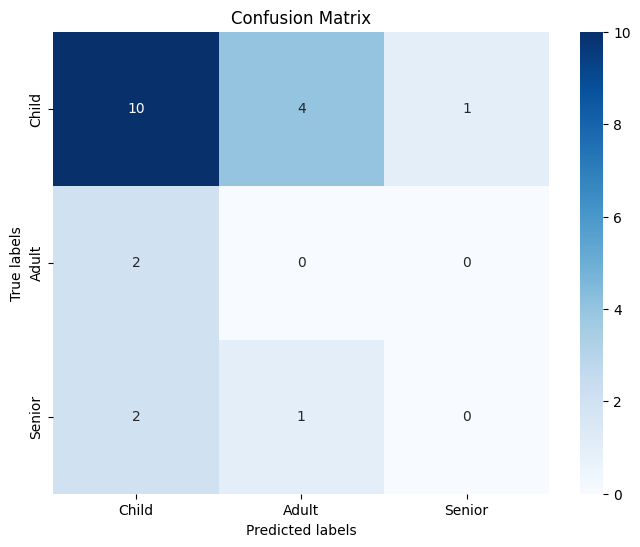

Classification Report:
               precision    recall  f1-score   support

       Child       0.71      0.67      0.69        15
       Adult       0.00      0.00      0.00         2
      Senior       0.00      0.00      0.00         3

    accuracy                           0.50        20
   macro avg       0.24      0.22      0.23        20
weighted avg       0.54      0.50      0.52        20



In [5]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

def resample_signal(x):
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return resample(x, 50, window='hamming', axis=0).flatten().tolist()

def to_nested(df):
    nested_df = pd.DataFrame({
        'keypoints': df['keypoints'],  
        'label': df['label']  
    })
    return nested_df

# Load data for different categories
child_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Children_left_right'
adult_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Adult_left_right'
senior_directory = 'F:/Backup_drive_1201201336/Fyp_gambatee/Time Series Analysis/Age_Prediction/S_dataset/Senior_left_right'

child_data = load_data(child_directory, start_video_id=1)
adult_data = load_data(adult_directory, start_video_id=21)  # Start from 21
senior_data = load_data(senior_directory, start_video_id=41)  # Start from 41

# Assign labels
child_data['label'] = 1
adult_data['label'] = 2
senior_data['label'] = 3

# Combine data
data = pd.concat([child_data, adult_data, senior_data])


grouped_data = data.groupby('video_id').agg({
    'keypoints': lambda x: np.sum(x.tolist(), axis=0),  # Sum keypoints lists
    'label': 'first'
}).reset_index()

# Resample keypoints
grouped_data['keypoints'] = grouped_data['keypoints'].apply(resample_signal)

nested_grouped_data = to_nested(grouped_data)

# Exchange data format
X = np.array(nested_grouped_data['keypoints'].tolist())
y = np.array(nested_grouped_data['label'])


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# Training on MultiRocketHydra Classifier
classifier =  MultiRocketHydraClassifier(n_kernels=8, n_groups=64, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train)


# Prediction
y_pred = classifier.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)
